 <font size="6"><p style="text-align:center"><b> Постройка модели для прогноза оттока клиентов банка "Бета-банк" </b></p></font>

<div class="alert alert-dan
            ger">
<font size="4"><b>План:</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

- В нашем распоряжении данные о поведении клиентов, которые уже расторгли договор с банком.  
        
- Обработаем данные и построим модель, которая даст прогноз о возможном уходе клиента.
        
- Это позволит сделать ставку на сохранение старых клиентов.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<font size="5"><p style="text-align:center"><b> ***Шаг 1. Обзор и предобработка данных*** </b></p></font>

In [ ]:
!pip install -U imbalanced-learn --user

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
try:
    data = pd.read_csv('C:/Users/Asus/Downloads/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце tenure есть пропуски - видимо, те люди, у которых срок пользования услугами банка менее года. 
Три столбца: фамилия, страна, пол - имеют объектный тип, поэтому их нужно изменить на количественный методом OHE для работы модели. При этом возникнет огромное количество столбцов с разными фамилиями. Условимся, что фамилия едва ли влияет на отказ от услуг банка, и удалим этот столбец, как и столбцы с номером строки и id.

Посмотрим, как данные выглядят в таблице.

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Изменим названия столбцов на стандартные - нижний регистр.

In [6]:
data.columns = data.columns.str.lower()

Удалим столбцы с фамилиями, номером строки, id. 

In [7]:
data.drop(['surname', 'rownumber', 'customerid'], axis = 1, inplace=True)

Так как пропусков в столбце tenure более 9%, и, вероятно, это те люди, у которых срок пользования услугами банка менее года, то не будем их удалять, заменим на константу.

In [8]:
data['tenure'].fillna('0', inplace=True)
data['tenure'] = data['tenure'].astype('int')

<font size="5"><p style="text-align:center"><b> ***Шаг 2. Исследование модели без учёта дисбаланса классов*** </b></p></font>

Исследуем дисбаланс классов.

0    0.7963
1    0.2037
Name: exited, dtype: float64


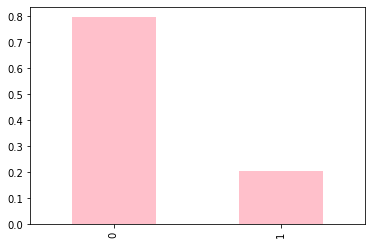

In [9]:
class_frequency = data['exited'].value_counts(normalize=data.shape)
print(class_frequency)
class_frequency.plot(kind='bar', color = 'pink');

Ушедших клиентов почти в 4 раза меньше оставшихся - дисбаланс классов есть.

Разделим датасет на три выборки в соотношении 3:1:1.

In [10]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345, shuffle=True, stratify=None)

data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=12345, shuffle=True, stratify=None)

In [11]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Масштабируем признаки.

In [12]:
numeric = ['creditscore', 'tenure', 'balance', 'age', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(data_train[numeric])
data_train[numeric] = scaler.transform(data_train[numeric])
data_valid[numeric] = scaler.transform(data_valid[numeric])
data_test[numeric] = scaler.transform(data_test[numeric])

In [13]:
data_train = pd.get_dummies(data_train, drop_first=True)
data_valid = pd.get_dummies(data_valid, drop_first=True)
data_test = pd.get_dummies(data_test, drop_first=True)

Разделим выборки на обучающие признаки и таргет.

In [14]:
features_train = data_train.drop('exited', axis=1)
target_train = data_train['exited']

features_valid = data_valid.drop('exited', axis=1)
target_valid = data_valid['exited']

features_test = data_test.drop('exited', axis=1)
target_test = data_test['exited']

Отберём необходимые признаки для большей генерализации модели.

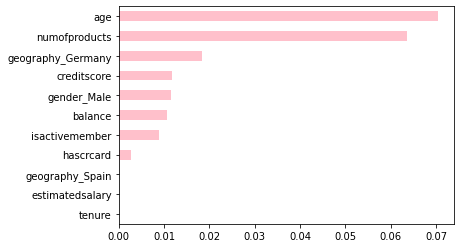

In [15]:
X = data_train.drop('exited', axis=1)
y = data_train['exited']
importances = mutual_info_classif(X=X, y=y)
feature_importances = pd.Series(importances, X.columns).sort_values()
feature_importances.plot(kind='barh', color='pink')
plt.show;

Большее значение на таргет имеют возраст и количество продуктов банка. Так как столбцов не так много, не будем удалять иные, имеющие малое значение на оси абсцисс.

Обучим модель логистической регрессии без учёта дисбаланса классов.

In [16]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.3056603773584906
ROC-AUC: 0.7708334989087915


Далее дерево решений.

In [17]:
best_model_dt = None
best_result = 0
best_result_1 = 0 
best_depth = 0

for depth in range(1,15):
    model = DecisionTreeClassifier(random_state=12345, splitter='best', max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_1 = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result and result_1 > best_result_1:
        best_model_dt = model
        best_result = result
        best_result_1 = result_1
        best_depth = depth
        
print('max_depth =', depth)
print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)

max_depth = 14
F1 лучшей модели: 0.5488958990536277
ROC-AUC лучшей модели: 0.8275652142122556


Случайный лес.

In [18]:
%%time

best_model_rf = None
best_result = 0
best_result_1 = 0 
best_depth = 0
best_est = 0
for est in range(50, 150, 5):

    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result_1 = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result and result_1 > best_result_1:
            best_model_rf = model
            best_result = result
            best_result_1 = result_1
            best_depth = depth
            best_est = est

print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)
print('max_depth =', best_depth)
print('n_estimators =', best_est)

F1 лучшей модели: 0.5639344262295082
ROC-AUC лучшей модели: 0.8515447792865897
max_depth = 11
n_estimators = 60
CPU times: user 2min 45s, sys: 961 ms, total: 2min 46s
Wall time: 2min 48s


In [19]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': range(50, 121, 5),
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 4),
}

model = RandomForestClassifier(random_state=96)

metrics = ['f1', 'roc_auc']

search = GridSearchCV(model, parameters, cv=4, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_

print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.5791
AUC-ROC on VALID: 0.8435
max_depth           10
min_samples_leaf     1
n_estimators        60
dtype: int64
CPU times: user 10min 55s, sys: 3.51 s, total: 10min 59s
Wall time: 11min 2s


*Вывод по обучению модели без учёта дисбаланса: лучшая F1-мера и площадь AUC-ROC у модели случайный лес. Однако до 0.59 F1-мера не дотягивает.*

<font size="5"><p style="text-align:center"><b> ***Шаг 3. Исследование модели с учётом дисбаланса классов*** </b></p></font>

Начнём улучшение метрик с метода балансировки классов.

In [20]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.47763864042933807
ROC-AUC: 0.7729634616026538


Теперь дерево решений.

In [21]:
best_model_dt = None
best_result = 0
best_result_1 = 0 
best_depth = 0

for depth in range(2,15):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', splitter='best', max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_1 = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result and result_1 > best_result_1:
        best_model_dt = model
        best_result = result
        best_result_1 = result_1
        best_depth = depth
        
print('max_depth =', depth)
print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)

max_depth = 14
F1 лучшей модели: 0.5489078822412156
ROC-AUC лучшей модели: 0.818801371441651


Теперь случайный лес.

In [22]:
%%time

best_model_rf = None
best_result = 0
best_result_1 = 0 
best_depth = 0
best_est = 0
for est in range(50, 150, 5):

    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result_1 = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result and result_1 > best_result_1:
            best_model_rf = model
            best_result = result
            best_result_1 = result_1
            best_depth = depth
            best_est = est

print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)
print('max_depth =', best_depth)
print('n_estimators =', best_est)

F1 лучшей модели: 0.6035805626598465
ROC-AUC лучшей модели: 0.8528291150005006
max_depth = 10
n_estimators = 50
CPU times: user 2min 40s, sys: 1.11 s, total: 2min 41s
Wall time: 2min 42s


*Вывод по обучению модели после использования балансирования весов классов: лучшие F1-мера и площадь AUC-ROC у модели случайный лес. У логистической регрессии метрики улучшились, у дерева решений F1-мера улучшилась, AUC-ROC снизилась.*

Применим иной метод - SMOTE.

In [23]:
sm = SMOTE(random_state=12345, k_neighbors=5)
features_train_res, target_train_res = sm.fit_resample(features_train, target_train)

In [24]:
lr = LogisticRegression(random_state=12345, solver='liblinear')
lr.fit(features_train_res, target_train_res)
predicted_valid = lr.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.48037383177570087
ROC-AUC: 0.7654783912105659


In [25]:
best_model_dt = None
best_result = 0
best_result_1 = 0 
best_depth = 0

for depth in range(2,15):
    model = DecisionTreeClassifier(random_state=12345, splitter='best', max_depth=depth)
    model.fit(features_train_res, target_train_res)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_1 = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result and result_1 > best_result_1:
        best_model_dt = model
        best_result = result
        best_result_1 = result_1
        best_depth = depth
        
print('max_depth =', depth)
print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)

max_depth = 14
F1 лучшей модели: 0.5504201680672269
ROC-AUC лучшей модели: 0.8096679642484172


In [26]:
%%time

best_model_rf = None
best_result = 0
best_result_1 = 0 
best_depth = 0
best_est = 0
for est in range(50, 150, 5):

    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_res, target_train_res)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result_1 = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result and result_1 > best_result_1:
            best_model_rf = model
            best_result = result
            best_result_1 = result_1
            best_depth = depth
            best_est = est

print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)
print('max_depth =', best_depth)
print('n_estimators =', best_est)

F1 лучшей модели: 0.5896860986547086
ROC-AUC лучшей модели: 0.8532280856245004
max_depth = 8
n_estimators = 115
CPU times: user 4min 6s, sys: 1.02 s, total: 4min 7s
Wall time: 4min 8s


Для ревьюера: читала про градиентный бустинг, но не нашла (хотя не очень активно искала), какая это библиотека, метод, функция и т.д. Его здесь вообще уместно будет использовать?

In [27]:
best_model_gb = None
best_result = 0
best_result_1 = 0 
best_depth = 0
best_est = 0

for est in range(50, 150, 5):

    for depth in range(2, 15):
        gb = GradientBoostingClassifier(random_state=12345, learning_rate=0.1, n_estimators=est, max_depth=depth)
        gb.fit(features_train_res, target_train_res)
        predictions_valid = gb.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        probabilities_valid = gb.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result_1 = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result and result_1 > best_result_1:
            best_model_gb = model
            best_result = result
            best_result_1 = result_1
            best_depth = depth
            best_est = est

print('F1 лучшей модели:', best_result)
print('ROC-AUC лучшей модели:', best_result_1)
print('max_depth =', best_depth)
print('n_estimators =', best_est)

F1 лучшей модели: 0.6164021164021164
ROC-AUC лучшей модели: 0.8627747691613193
max_depth = 4
n_estimators = 135


*Вывод по обучению модели после использования SMOTE: лучшая F1-мера (0.89) и площадь AUC-ROC (0.96) у модели градиентного бустинга, далее случайный лес. До 0.59 F1-мера выросла у всех моделей. AUC-ROC выросла у всех моделей.*

<font size="5"><p style="text-align:center"><b> ***Шаг 4. Тестирование*** </b></p></font>

Тестируем модель случайный лес.

In [28]:
rf = RandomForestClassifier(random_state=12345, n_estimators=115, max_depth=8)
rf.fit(features_train_res, target_train_res)
predictions = rf.predict(features_test)

print('F1:', f1_score(target_test, predictions))

probabilities_test = rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.6091370558375635
ROC-AUC: 0.8520868103580475


Тестируем модель градиентный бустинг.

In [29]:
gb = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=135, max_depth=2)
gb.fit(features_train_res, target_train_res)
predictions = gb.predict(features_test)

print('F1:', f1_score(target_test, predictions))

probabilities_test = gb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.6345123258306538
ROC-AUC: 0.8627445579755565


Попробуем конкатенировать выборки и вновь тестировать модель случайный лес.

In [30]:
features = pd.concat([features_train_res, features_valid])
target = pd.concat([target_train_res, target_valid])
rf.fit(features, target)
predictions = rf.predict(features_test)
print('F1:', f1_score(target_test, predictions))

probabilities_test = rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.6298342541436465
ROC-AUC: 0.8563522915236776


Теперь градиентный бустинг после объединения выборок.

In [31]:
gb.fit(features, target)
predictions = gb.predict(features_test)
print('F1:', f1_score(target_test, predictions))

probabilities_test = gb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.6453143534994069
ROC-AUC: 0.8669065658633469


Дообучение немного повысило метрики.

Проверим модель на вменяемость.

In [32]:
print('Accuracy:', rf.score(features_test, target_test))

Accuracy: 0.8325


In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_test)
dummy_clf.score(features_test, target_test)

0.7865

Модель адекватна.

<font size="5"><p style="text-align:center"><b> ***Вывод*** </b></p></font>

1. Мы выполнили обзор данных: таблицы со сведениями о поведении клиентов банка. Устранили неинформативные признаки, применили прямое кодирование объектных признаков, масштабирование числовых небинарных признаков. Разделили данные на обучающую, валидационную и тестовую выборки.

2. Выявили дисбаланс классов. Создали несколько моделей для задачи классификации, выявили оптимальные гиперпараметры, определили метрики без учёта дисбаланса классов.

3. Далее обучили модели с учётом дисбаланса классов, обнаружили, что лучшие F1-мера и ROC-AUC у модели градиентного бустинга и случайного леса.

3. При тестировании модели на тестовой выборке добились значения 0.65 для F1-меры и 0.87 для ROC-AUC.

4. Проверили нашу модель на вменяемость.

Лучшей моделью для подбора тарифа для прогноза оттока клиентов банка "Бета-банк" является модель "градиентный бустинг".